In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageEnhance
import cv2
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from kneed import KneeLocator

In [2]:
dataset_path = "../dataset/dataset_metadata/test_set.csv"
df = pd.read_csv(dataset_path)

In [3]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    enhancer = ImageEnhance.Contrast(image)
    enhanced_image = enhancer.enhance(2.0)
    image_np = np.array(enhanced_image)
    blurred_image = cv2.GaussianBlur(image_np, (5, 5), 0)
    return blurred_image

In [4]:
def apply_kmeans(image_np, k=2):
    mask = ~(np.all(image_np == [0, 0, 0], axis=-1))
    valid_pixels = image_np[mask]
    pixels = valid_pixels.reshape((-1, 3)).astype(float)
    pixels /= 255.0
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(pixels)
    labels = np.full(image_np.shape[:2], -1)
    labels[mask.reshape(image_np.shape[:2])] = kmeans.labels_
    centroids = kmeans.cluster_centers_
    return labels, centroids

In [5]:
def analyze_clusters(image_np, labels, centroids, k=2):
    height, width, _ = image_np.shape
    label_image = labels.reshape((height, width))
    cluster_sizes = [np.sum(labels == i) for i in range(k)]
    smaller_cluster_idx = np.argmin(cluster_sizes)
    smaller_cluster_size = cluster_sizes[smaller_cluster_idx]
    cluster_mean_diff = np.linalg.norm(centroids[0] - centroids[1])    
    return label_image, smaller_cluster_idx, smaller_cluster_size, cluster_mean_diff

In [6]:
def calculate_metrics(image_np, labels, centroids, k):
    mask = ~(np.all(image_np == [0, 0, 0], axis=-1))
    valid_pixels = image_np[mask].reshape(-1, 3) / 255.0

    distances = np.linalg.norm(valid_pixels - centroids[labels[mask]], axis=1) ** 2
    inertia = np.sum(distances)
    
    silhouette = silhouette_score(valid_pixels, labels[mask]) if k > 1 else 0

    calinski_harabasz = calinski_harabasz_score(valid_pixels, labels[mask]) # aim for atleast 100000 based on our dataset
    
    return inertia, silhouette, calinski_harabasz

In [7]:
def find_best_k(k_values, inertia_scores, silhouette_scores, calinski_scores):
    knee_locator = KneeLocator(k_values, inertia_scores, curve="convex", direction="decreasing")
    elbow_k = knee_locator.knee
    
    best_silhouette_k = k_values[np.argmax(silhouette_scores)]
    
    best_ch_k = k_values[np.argmax(calinski_scores)]
    
    optimal_k = int(round((elbow_k + best_silhouette_k + best_ch_k) / 3)) # equal weights?
    return optimal_k, elbow_k, best_silhouette_k, best_ch_k

In [8]:
def predict_health(k, centroids, green_threshold=0.35, color_distance_threshold=0.4):
    if k > 4:
        return 0

    healthy_green = np.array([0.2, 0.6, 0.2])  # adjust?

    green_distances = [np.linalg.norm(centroid - healthy_green) for centroid in centroids]

    if min(green_distances) > green_threshold:
        return 0

    color_distances = []
    for i in range(len(centroids)):
        for j in range(i + 1, len(centroids)):
            distance = np.linalg.norm(centroids[i] - centroids[j])
            color_distances.append(distance)

    if max(color_distances) > color_distance_threshold:
        return 0

    return 1

In [9]:
sample_idx = 0
sample = df.iloc[sample_idx]
category, filename = sample["category"], sample["filename"]
image_path = os.path.join("../dataset/raw", category, filename)
processed_image = preprocess_image(image_path)
labels, centroids = apply_kmeans(processed_image, k=2)
label_image, smaller_cluster_idx, smaller_cluster_size, cluster_mean_diff = analyze_clusters(processed_image, labels, centroids)
print(f"Smaller cluster size: {smaller_cluster_size}")
print(f"Cluster mean difference: {cluster_mean_diff}")

Smaller cluster size: 20147
Cluster mean difference: 0.6025794775187122


In [10]:
def visualization(image_np, labels, centroids, silhouette_scores, inertia_scores, calinski_scores, k_values, k):
    label_image = labels.reshape(image_np.shape[:2])
    cluster_colors = np.random.randint(0, 255, size=(len(centroids), 3), dtype=np.uint8)
    clustered_image = cluster_colors[label_image]
    
    _, axes = plt.subplots(3, 2, figsize=(14, 15))
    axes = axes.ravel()

    axes[0].imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # overlay_image = cv2.addWeighted(image_np, 0.6, clustered_image, 0.4, 0)
    axes[1].imshow(clustered_image)
    axes[1].set_title(f"Clustered Image (K={k})")
    axes[1].axis("off")

    axes[2].plot(k_values, silhouette_scores, marker='o', color='blue', label="Silhouette Score")
    axes[2].set_title("Silhouette Scores")
    axes[2].set_xlabel("Number of Clusters (K)")
    axes[2].set_ylabel("Silhouette Score")
    axes[2].grid(True)
    axes[2].legend()

    axes[3].plot(k_values, inertia_scores, marker='o', color='green', label="Inertia")
    axes[3].set_title("Inertia Scores")
    axes[3].set_xlabel("Number of Clusters (K)")
    axes[3].set_ylabel("Inertia")
    axes[3].grid(True)

    knee_locator = KneeLocator(k_values, inertia_scores, curve="convex", direction="decreasing")
    optimal_k = knee_locator.knee
    axes[3].axvline(optimal_k, color='orange', linestyle='--', label=f'Elbow at K={optimal_k}')
    axes[3].legend()

    axes[4].plot(k_values, calinski_scores, marker='o', color='red', label="Calinski-Harabasz Index")
    axes[4].set_title("Calinski-Harabasz Scores")
    axes[4].set_xlabel("Number of Clusters (K)")
    axes[4].set_ylabel("Calinski-Harabasz Index")
    axes[4].grid(True)
    axes[4].legend()

    for i, centroid in enumerate(centroids):
        color = centroid * 255
        axes[5].bar(i, 1, color=color/255.0, edgecolor='black')
    axes[5].set_title("Centroids (Colors)")
    axes[5].set_xticks(range(len(centroids)))
    axes[5].set_xticklabels([f"Cluster {i+1}" for i in range(len(centroids))])
    axes[5].set_yticks([])

    plt.tight_layout()
    os.makedirs('../images', exist_ok=True)
    plt.savefig('../images/kmeans_visualization.png')
    plt.show()

In [11]:
# Initialize arrays for storing metrics
k_values = range(2, 10)
silhouette_scores = []
inertia_scores = []
calinski_scores = []

# Compute metrics for each k
for k in tqdm(k_values):
    labels, centroids = apply_kmeans(processed_image, k=k)
    inertia, silhouette, ch = calculate_metrics(image_np=processed_image, labels=labels, centroids=centroids, k=k)
    silhouette_scores.append(silhouette)
    inertia_scores.append(inertia)
    calinski_scores.append(ch)

optimal_k, elbow_k, best_silhouette_k, best_ch_k = find_best_k(k_values, inertia_scores, silhouette_scores, calinski_scores)
print(f"Optimal K combining 3 metrics: {optimal_k}, Optimal Inertia K: {elbow_k}, Optimal Silhouette K: {best_silhouette_k}, Optimal CH Index K: {best_ch_k}")

100%|██████████| 8/8 [02:03<00:00, 15.47s/it]

Optimal K combining 3 metrics: 3, Optimal Inertia K: 4, Optimal Silhouette K: 2, Optimal CH Index K: 4


In [14]:
ground_truth_labels = df['disease_type'].apply(lambda x: 1 if x == 'healthy' else 0).values
predictions = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    category, filename = row["category"], row["filename"]
    image_path = os.path.join("../dataset/raw", category, filename)
    
    processed_image = preprocess_image(image_path)
    
    labels, centroids = apply_kmeans(processed_image, k=optimal_k)
    
    prediction = predict_health(optimal_k, centroids)
    predictions.append(prediction)

predictions = np.array(predictions)

correct_predictions = np.sum(predictions == ground_truth_labels)
accuracy = correct_predictions / len(ground_truth_labels) * 100

print(f"Accuracy using optimal K across entire dataset: {accuracy:.2f}%")

100%|██████████| 2170/2170 [02:15<00:00, 16.00it/s]

Accuracy using optimal K across entire dataset: 71.43%


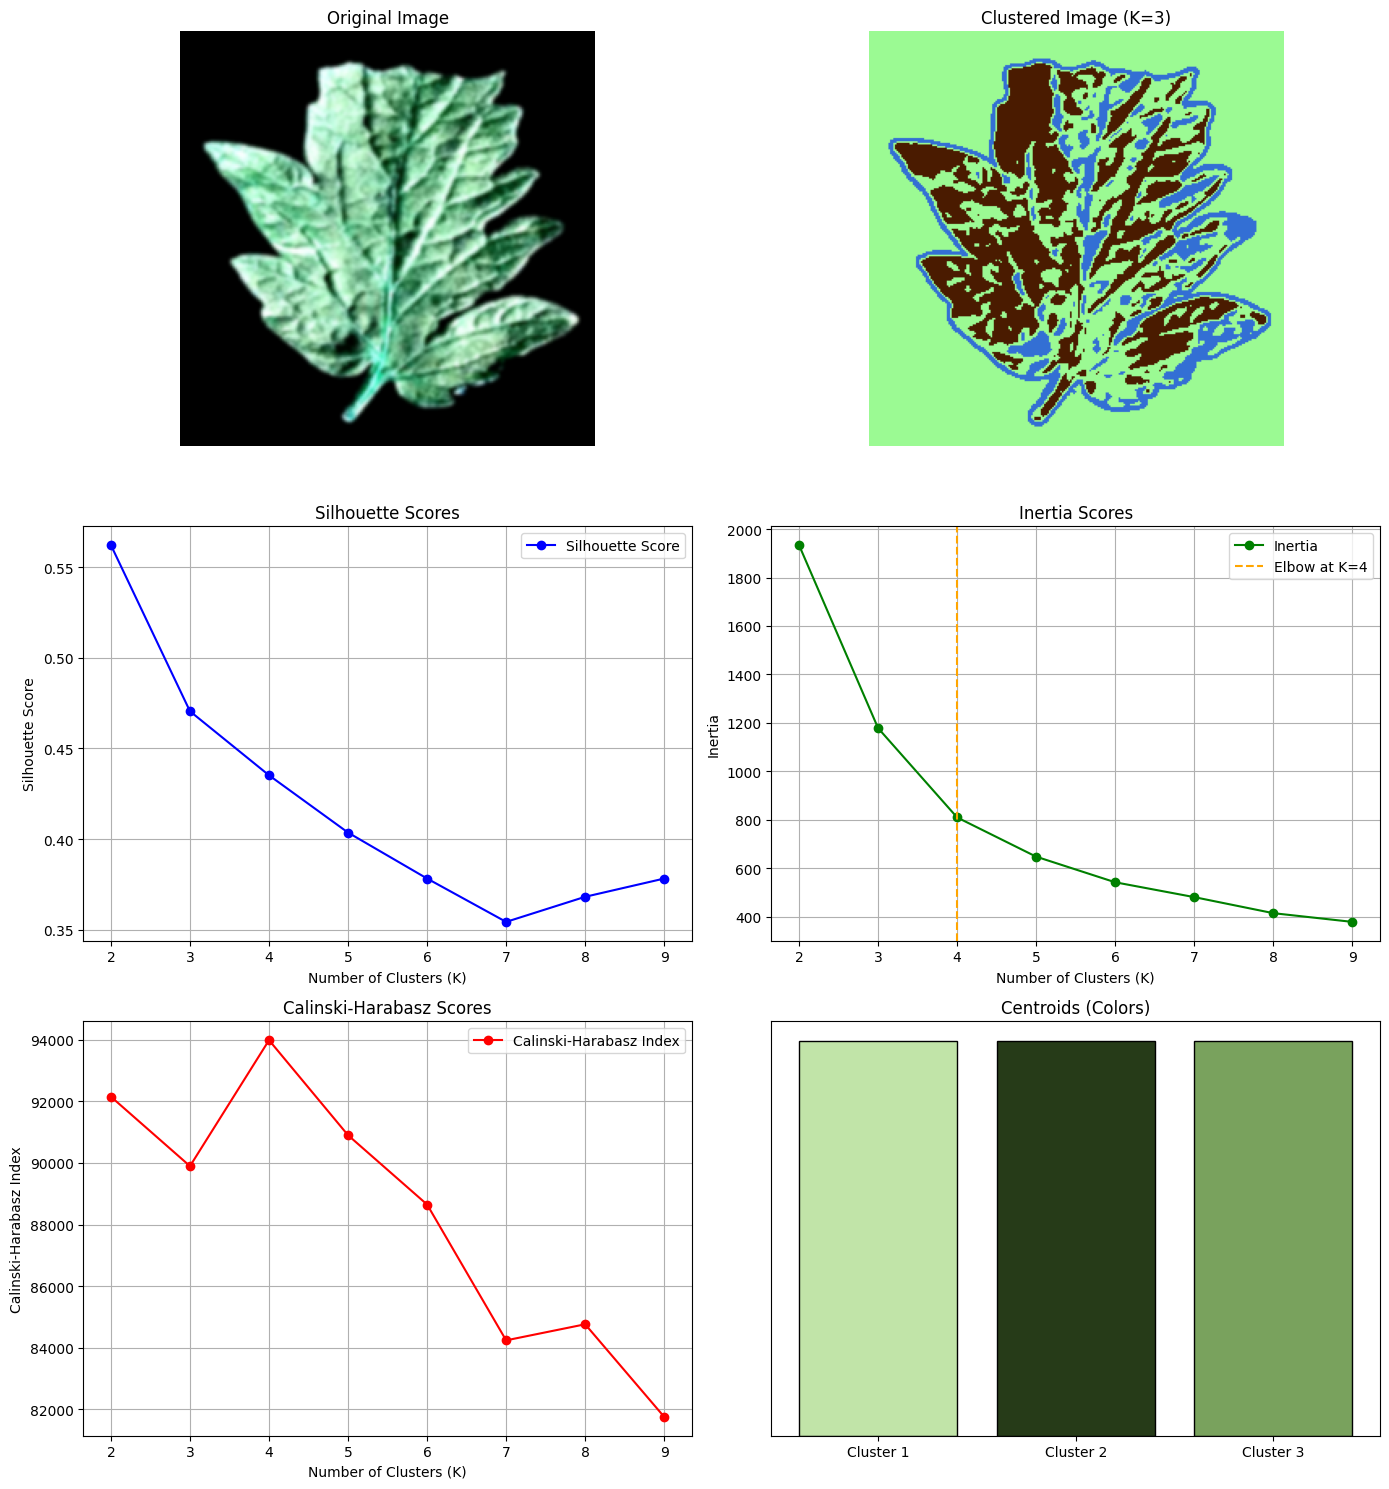

In [17]:
visualization(processed_image, labels, centroids, silhouette_scores, inertia_scores, calinski_scores, k_values, optimal_k)